In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv("diabetes_prediction_dataset.csv")

In [3]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
#Encode the data
data = pd.read_csv("diabetes_prediction_dataset.csv")
data['gender'] = [ 1 if data['gender'].to_numpy()[i]=="Female" else 0 for i in range(len(data['gender'].to_numpy())) ]

one_hot_encoded = pd.get_dummies(data['smoking_history'])
data = pd.concat([one_hot_encoded, data], axis=1)
data = data.drop("smoking_history",axis=1)

#normalize each cfeature by dividing by the maximum
data = data / data.max()

In [5]:
data

,No Info,current,ever,former,never,not current,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0000,0.0,1.0,0.263246,0.733333,0.466667,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6750,0.0,0.0,0.285505,0.733333,0.266667,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.3500,0.0,0.0,0.285505,0.633333,0.526667,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.4500,0.0,0.0,0.245062,0.555556,0.516667,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.9500,1.0,1.0,0.210471,0.533333,0.516667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0000,0.0,0.0,0.285505,0.688889,0.300000,0.0
99996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0250,0.0,0.0,0.181524,0.722222,0.333333,0.0
99997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.8250,0.0,0.0,0.290835,0.633333,0.516667,0.0
99998,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.3000,0.0,0.0,0.370154,0.444444,0.333333,0.0


We now want to check if there are duplicate rows, if so, we will drop them as this will impact our model's prediction. Indeed, if the test data contains data that the model has already been trained on, then the model will have a high accuracy, but we will not know how it would perform with data it has never seen. 

In [6]:
data.duplicated()
print(f'There are {data.duplicated().sum()} duplicate rows')

There are 3857 duplicate rows


In [7]:
data.drop_duplicates(inplace=True)
data

,No Info,current,ever,former,never,not current,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0000,0.0,1.0,0.263246,0.733333,0.466667,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6750,0.0,0.0,0.285505,0.733333,0.266667,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.3500,0.0,0.0,0.285505,0.633333,0.526667,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.4500,0.0,0.0,0.245062,0.555556,0.516667,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.9500,1.0,1.0,0.210471,0.533333,0.516667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.4500,0.0,0.0,0.257080,0.533333,0.483333,0.0
99996,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0250,0.0,0.0,0.181524,0.722222,0.333333,0.0
99997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.8250,0.0,0.0,0.290835,0.633333,0.516667,0.0
99998,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.3000,0.0,0.0,0.370154,0.444444,0.333333,0.0


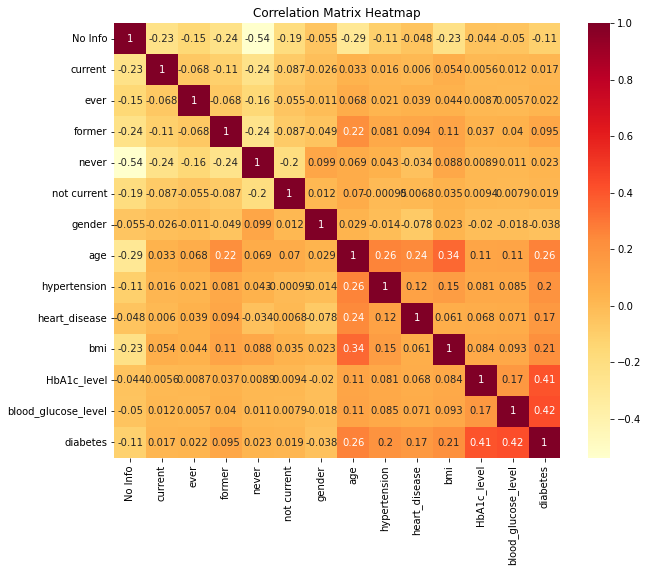

In [8]:
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlOrRd")
plt.title("Correlation Matrix Heatmap")
plt.show()

We notice that age is very correlated to hypertension, heart_disease and the bmi. We will see in the future if we can improve the model by removing those three features.

We notice that diabetes is very correlated to HbA1c_level and blood_glucose_level.



In [9]:
corr_list_with_diabetes = dict(corr_matrix['diabetes'])
corr_list_with_diabetes_sorted = {k: abs(v) for k, v in sorted(corr_list_with_diabetes.items(), key=lambda item: abs(item[1]))}

print(corr_list_with_diabetes_sorted)



{'current': 0.01703401169121257, 'not current': 0.018918912201574767, 'ever': 0.021912679048656025, 'never': 0.023128943425234194, 'gender': 0.03777495463149874, 'former': 0.0954886464816394, 'No Info': 0.11256622577674917, 'heart_disease': 0.17070926680677048, 'hypertension': 0.19570743886646758, 'bmi': 0.21493202231672048, 'age': 0.26492188964168023, 'HbA1c_level': 0.4064124530648969, 'blood_glucose_level': 0.42434311785511997, 'diabetes': 1.0}


In [10]:
isnasum = data.isna().sum()
num_duplicates = data.duplicated().sum()
print("Number of duplicates:", num_duplicates, "\nNumber of NaN values:\n", isnasum)

Number of duplicates: 0 
Number of NaN values:
 No Info                0
current                0
ever                   0
former                 0
never                  0
not current            0
gender                 0
age                    0
hypertension           0
heart_disease          0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [11]:
s = sum(data['No Info'].to_numpy())
print(f"We have no info on the smoking habits of {s} patients.")

We have no info on the smoking habits of 32884.0 patients.


In [12]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1:]
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25,random_state = 42)
X_train, Y_train = X_train.to_numpy(), Y_train.to_numpy()[:,0]

In [13]:
X_train.shape

(72107, 13)

In [14]:
Y_train

array([0., 0., 0., ..., 0., 0., 0.])

## Logistic Regression

We will now build a logistic regression model in order to predict whether an individual has diabetes or not. In our project, we are faced with a binary logistic regression, as our output variable 'diabetes' has only 2 classes. 

In [15]:
classifier = linear_model.LogisticRegression()
classifier.fit(X_train, Y_train)

NameError: name 'linear_model' is not defined

We start with an arbitrary value for C, the inverse of the regularization strength, and we will later explore what value of C to use in order to improve our model the most.

In [ ]:
y_pred = classifier.predict(X_test)

accuracy_score(Y_test, y_pred)

## K nearest neighbours

In [16]:
import sklearn.neighbors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


Let us try with different number of neighbours and plot the accuracy of the predictions. 

/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sk

[0.9429189549009819, 0.9562323181893826, 0.9539440838741887, 0.9573140289565651, 0.9569395906140788, 0.9572308204360126, 0.9568147778332501, 0.9567315693126976, 0.9572308204360126, 0.9564819437510401, 0.9578548843401564, 0.9566067565318689, 0.9580213013812614, 0.9565651522715926]


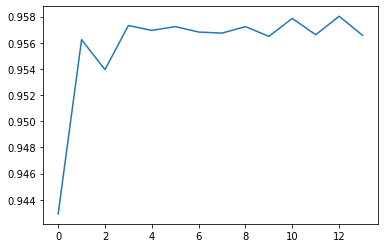

In [18]:
accuracy=[]
for n in range(1,15):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train,Y_train)
    predictions=model.predict(X_test)
    accuracy+=[accuracy_score(Y_test,predictions)]
    
print(accuracy)
plt.plot(accuracy)
plt.show()

The accuracy is already really good. Let us do a PCA.

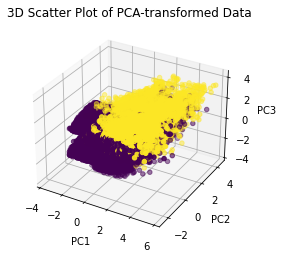

In [25]:
names=['No info','current','ever','former','never','not current','gender','age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level']

pca = decomposition.PCA(n_components=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
# Plot the 3D scatter plot of the PCA-transformed data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],c=Y)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of PCA-transformed Data')
plt.show()

[0.8758112830753869, 0.9161674155433517, 0.9337244133799301, 0.9536112497919786, 0.9523631219836911, 0.9544433349975038, 0.9539024796139125, 0.9549425861208187, 0.9545265435180562, 0.9603927442170078, 0.9595190547512065, 0.9574388417373939, 0.9584373439840239]


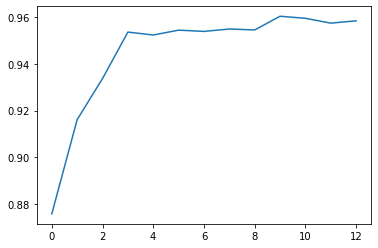

In [27]:
accuracy=[]
for n in range(1,14):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.25,random_state = 42)
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    Y_train = Y_train.to_numpy().ravel()
    Y_test = Y_test.to_numpy().ravel()
    model.fit(X_train, Y_train)

    predictions=model.predict(X_test)
    accuracy+=[accuracy_score(Y_test,predictions)]
    

print(accuracy)
plt.plot(accuracy)
plt.show()